<a href="https://colab.research.google.com/github/kaybrian/Chatbot_ML_T1/blob/main/Chatbot_using_Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the Librraries
First step in the process is going to be loading all the libraries needed


In [1]:
import numpy as np
import pandas as pd
import re
import random
import transformers
import matplotlib.pyplot as plt
import json
import pickle
import torch

import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Activation,Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras import metrics
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model

/usr/local/Caskroom/miniconda/base/envs/roline/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to /Users/kaybrian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kaybrian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
2024-10-23 09:55:51.495819: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### import the transformers library


In [2]:
from transformers import BertTokenizer, BertModel
from sklearn.preprocessing import LabelBinarizer

# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Import BERT-base pretrained model
bert_model = BertModel.from_pretrained('bert-base-uncased')

## load the data

The data to use in the project is loaded in the processed data as data.csv

In [4]:
df = pd.read_csv("../data/processed/data.csv")
df.head()

,Questions,Answers,Patterns,Tags
0,What to do if Cuts?,Wash the cut properly to prevent infection and...,"What to do if Cuts?,How to cure Cuts?,Which me...",Cuts
1,How to cure Cuts?,Wash the cut properly to prevent infection and...,"What to do if Cuts?,How to cure Cuts?,Which me...",Cuts
2,Which medicine to apply for Cuts?,Wash the cut properly to prevent infection and...,"What to do if Cuts?,How to cure Cuts?,Which me...",Cuts
3,what to apply on cuts?,Wash the cut properly to prevent infection and...,"What to do if Cuts?,How to cure Cuts?,Which me...",Cuts
4,Cuts,Wash the cut properly to prevent infection and...,"What to do if Cuts?,How to cure Cuts?,Which me...",Cuts


In [6]:
# Creating intents dictionary
dict_ = {"intents": []}

for ind in df.index:
    questions = df['Questions'][ind].lower().replace('?', '.').split('.')
    patterns = [q.strip() for q in questions if q.strip()]
    patterns.append(df['Patterns'][ind].lower().strip())
    responses = df['Answers'][ind]
    tag = df['Tags'][ind]

    dict1 = {'tags': [tag], 'patterns': patterns, 'responses': [responses]}
    dict_['intents'].append(dict1)

print(dict_["intents"][:2])

with open("../data/chat/data.json", "w") as f:
    json.dump(dict_, f)

[{'tags': ['Cuts'], 'patterns': ['what to do if cuts', 'what to do if cuts?,how to cure cuts?,which medicine to apply for cuts?,what to apply on cuts?,cuts'], 'responses': ['Wash the cut properly to prevent infection and stop the bleeding by applying pressure for 1-2minutes until bleeding stops. Apply Petroleum Jelly to make sure that the wound is moist for quick healing. Finally cover the cut with a sterile bandage. Pain relievers such as acetaminophen can be applied.']}, {'tags': ['Cuts'], 'patterns': ['how to cure cuts', 'what to do if cuts?,how to cure cuts?,which medicine to apply for cuts?,what to apply on cuts?,cuts'], 'responses': ['Wash the cut properly to prevent infection and stop the bleeding by applying pressure for 1-2minutes until bleeding stops. Apply Petroleum Jelly to make sure that the wound is moist for quick healing. Finally cover the cut with a sterile bandage. Pain relievers such as acetaminophen can be applied.']}]


### Save the intents and all the needed information

The intents and all the information are saved in the data.json

In [7]:
words=[]
classes=[]
documents=[]
ignore_letters=['?','!','.',',']
lemmatizer = WordNetLemmatizer()

def get_bert_embedding(sentence):
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).detach().numpy()

for intent in dict_['intents']:
    for pattern in intent['patterns']:
        if isinstance(pattern, str):
            word_list = tokenizer.tokenize(pattern)
            words.extend(word_list)
            documents.append((pattern, intent['tags'][0]))
            if intent['tags'][0] not in classes:
                classes.append(intent['tags'][0])

words = [lemmatizer.lemmatize(word.lower()) for word in words if word not in ignore_letters]
words = sorted(set(words))
classes = sorted(set(classes))

pickle.dump(words, open('../data/model/words.pkl', 'wb'))
pickle.dump(classes, open('../data/model/classes.pkl', 'wb'))

In [8]:
# Prepare training data
training = []
output_empty = [0] * len(classes)
label_binarizer = LabelBinarizer()
label_binarizer.fit(classes)

for document in documents:
    pattern = document[0]
    tag = document[1]
    embedding = get_bert_embedding(pattern)
    output_row = label_binarizer.transform([tag])[0]
    training.append((embedding.flatten(), output_row))

random.shuffle(training)
training = np.array(training, dtype=object)

train_x = np.array([item[0] for item in training])
train_y = np.array([item[1] for item in training])

### Train the model 


In [9]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

model=Sequential()
model.add(Dense(128,input_shape=(len(train_x[1]),),activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(len(train_y[0]),activation='softmax'))


# Define learning rate schedule
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True
)

# Use the SGD optimizer with the learning rate schedule
sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
# sgd=SGD(learning_rate=0.0001,decay=1e-6,momentum=0.9,nesterov=True)


model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy','Precision','Recall'])
# model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=METRICS)
model.summary()
plot_model(model, to_file='../data/train/model.png', show_shapes=True)

/usr/local/Caskroom/miniconda/base/envs/roline/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 44)             │         2,860 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 109,548 (427.92 KB)

 Trainable params: 109,548 (427.92 KB)

 Non-trainable params: 0 (0.00 B)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [10]:
hist = model.fit(np.array(train_x),np.array(train_y),epochs=50,batch_size=12,verbose=1)
model.save('../data/model/chatbotmodel.h5', hist)
print('Training Done')

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0192 - loss: 3.8339
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - Precision: 0.0000e+00 - Recall: 0.0000e+00 - accuracy: 0.0726 - loss: 3.6928
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.4722 - Recall: 0.0024 - accuracy: 0.1086 - loss: 3.5683    
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 1.0000 - Recall: 0.0242 - accuracy: 0.1586 - loss: 3.2867
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.9429 - Recall: 0.0247 - accuracy: 0.2520 - loss: 3.0327      
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.9438 - Recall: 0.0536 - accuracy: 0.3374 - loss: 2.6122      
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - Precision: 0.9435 - Recall: 0.0763 - accuracy: 0.4405 - loss: 2.3509
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - Precision: 0.9369 - Recall: 0.1119 - accuracy: 0.5007 - loss: 1.9575:

Training Done


### plot the training data

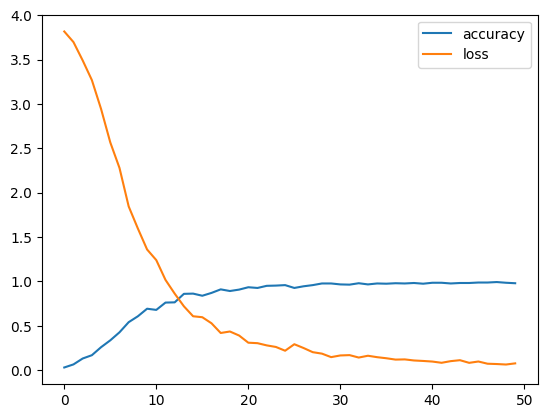

In [11]:
plt.plot(hist.history['accuracy'],label='accuracy')
plt.plot(hist.history['loss'],label='loss')
# plt.show()
plt.legend()

### test the trained model

In the section we need to try out our modle to see how its performing 

In [ ]:
# Load the model for prediction
model = load_model('../data/model/chatbotmodel.h5')

def predict_class(sentence):
    embedding = get_bert_embedding(sentence)
    res = model.predict(embedding)[0]
    ERROR_THRESHOLD = 0.25
    results = [[i, r] for i, r in enumerate(res) if r > ERROR_THRESHOLD]
    results.sort(key=lambda x: x[1], reverse=True)
    return_list = [{'intent': classes[r[0]], 'probability': str(r[1])} for r in results]
    return return_list

def get_response(intents_list, intents_json):
    tag = intents_list[0]['intent']
    for i in intents_json['intents']:
        if tag in i['tags']:
            return random.choice(i['responses'])
    return "Sorry, I don't understand."

print("GO! BOT IS RUNNING")

while True:
    message = input("")
    if message.lower() in ['quit', 'exit']:
        print("Goodbye")
        break
    ints = predict_class(message)
    if ints:
        res = get_response(ints, dict_)
        print(f"Bot: {res}")
    else:
        print("Bot: Sorry, I don't understand.")

GO! BOT IS RUNNING
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
Bot: Wash the cut properly to prevent infection and stop the bleeding by applying pressure for 1-2minutes until bleeding stops. Apply Petroleum Jelly to make sure that the wound is moist for quick healing. Finally cover the cut with a sterile bandage. Pain relievers such as acetaminophen can be applied.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Bot: Begin with washed hands.Gently clean the area with cool to lukewarm water and mild soap. Remove dirt or other particles from the wound using sterilized tweezers.For a mild scrape that’s not bleeding, leave the wound uncovered.If the wound is bleeding, use a clean cloth or bandage, and apply gentle pressure to the area to stop any bleeding.Cover a wound that bled with a thin layer of topical antibiotic ointment, like Bacitracin, or a sterile moisture barrier ointment, like Aquaphor. Cover it with a clean bandage or gauze. Gently clean the wound and change the ointment and bandage once per